# Restaurant Recommender

## Table of Contents

1. [Plan of attack](#Plan-of-attack)<br>
2. [Loading data](#Loading)<br>
3. [Initial FunkSVD Model](#Initial-FunkSVD-Model)<br>

### <a class="anchor" id="Plan-of-attack">Plan of Attack </a>

- Clean
    - [x] Date to date column 
    - [x] Select only users who've had more than 20 reviews (should be a few thousand)
    - [ ] Output to pickle/json
    - [ ] Duplicates
    - [x] NaNs
    - [x] Outlying dates/stars
- EDA
    - [ ] Most reviewed restaurants, can we cut out restaurants with few reviews and come back to them later?
    - [ ] Most prolific users
    - [ ] Plot restaurants on heatmap and on clustered point map in prep for knowledge based search.
    - [ ] How many times were restaurants reviewed by the same person more than once.  Keep the most recent review?
- FunkSVD
    - [ ] Train test
    - [ ] Exectute
    - [ ] Score on unseen data
    - [ ] Use [numba version](https://github.com/gbolmier/funk-svd) of FunkSVD to speed up runtime
- Edge cases
    - [ ] Cold start for users
    - [ ] Cold start for restaurants
- Recommendations
    - [ ] Best predicted ratings from FunkSVD for powerusers
    - [ ] Top in area for new users
    - [ ] Possibly implement knowledge based on extra features of restaurants

### <a class="anchor" id="Loading"> Loading Data </a>

In [644]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [138]:
def pick_lines_and_load(line):
    '''
    Args:
    Returns:
    '''
    line_json = json.loads(line)
    line = dict( [k,v] for k,v in line_json.items() if k in columns_to_keep) 
    return line
    
def read_in_json(filepath):
    '''The Yelp json files are one json per row, so 
    Args:
    Returns:
    
    '''
    with open(filepath) as json_file:      
        data = json_file.readlines()
        data = list(map(pick_lines_and_load, data)) 

    return pd.DataFrame(data)

def get_file_structure(filepath):
    '''Gets the file structure of the input file by reading a single line 
    Args:
    Returns:
    
    '''
    with open(filepath) as json_file:      
        data = json_file.readlines(1)
        data = list(map(json.loads, data)) 

    return pd.DataFrame(data)

In [390]:
get_file_structure('../../../YelpData/yelp_academic_dataset_business.json')
columns_to_keep = ['business_id','name','city','latitude','longitude','review_count','categories']

In [391]:
df_businesses = read_in_json('../../../YelpData/yelp_academic_dataset_business.json')



In [392]:
df_businesses.head()

,business_id,name,city,latitude,longitude,review_count,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,Cornelius,35.462724,-80.852612,36,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD",Scottsdale,33.569404,-111.890264,4,"Health & Medical, Fitness & Instruction, Yoga,..."
2,XNoUzKckATkOD1hP6vghZg,Felinus,Montreal,45.479984,-73.580070,5,"Pets, Pet Services, Pet Groomers"
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,North Las Vegas,36.219728,-115.127725,3,"Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,Mesa,33.428065,-111.726648,26,"Home Services, Plumbing, Electricians, Handyma..."


In [426]:
# How many nulls in each columns?
df_businesses.isna().mean()

business_id     0.000000
name            0.000000
city            0.000000
latitude        0.000000
longitude       0.000000
review_count    0.000000
categories      0.002502
dtype: float64

In [430]:
# Drop businesses without a category
df_businesses.dropna(subset = ['categories'], inplace=True)
df_businesses.isna().mean()

business_id     0.0
name            0.0
city            0.0
latitude        0.0
longitude       0.0
review_count    0.0
categories      0.0
dtype: float64

In [431]:
categories = df_businesses.categories.str.split(',').explode().str.strip()

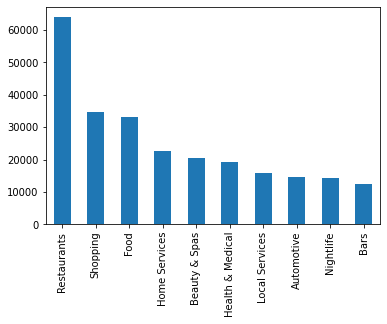

In [432]:
categories.value_counts()[:10].plot(kind='bar');

In [616]:
# Keep only business which contain Restaurant in their category list
df_businesses = df_businesses[df_businesses.categories.str.split(',').apply(lambda x: 'Restaurants' in x)]
df_businesses.shape

(19456, 7)

In [618]:
df_businesses_toronto = df_businesses[df_businesses.city == 'Toronto']

In [135]:
review_filepath = '../../../YelpData/yelp_academic_dataset_review.json'
get_file_structure(review_filepath)
columns_to_keep = ['review_id','user_id','business_id','stars','useful','funny','cool','date']

df_reviews = read_in_json(review_filepath)

In [141]:
df_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,2017-01-14 21:56:57


In [442]:
df_reviews_city = df_reviews.merge(df_businesses[['business_id','city']], on='business_id')

In [443]:
city_counts = df_reviews_city.groupby('city').review_id.count()

In [444]:
city_counts.sort_values(ascending = False)

city
Las Vegas                368047
Phoenix                  139547
Toronto                  125432
Scottsdale                63989
Charlotte                 58330
                          ...  
Black Earth                   3
RŽpentigny                    3
Saint-Basile-le-Grand         3
Bellvue                       3
Coteau-Du-Lac                 3
Name: review_id, Length: 537, dtype: int64

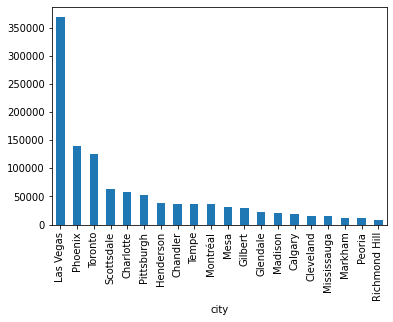

In [446]:
city_counts.sort_values(ascending = False)[:20].plot(kind = 'bar');

In [447]:
user_counts = df_reviews_city.groupby('city').user_id.nunique()

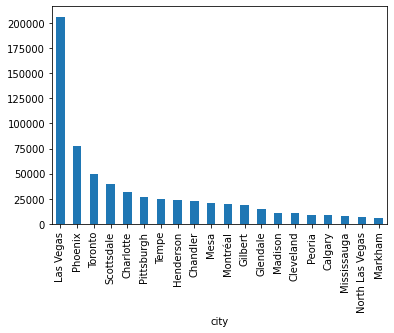

In [448]:
user_counts.sort_values(ascending = False)[:20].plot(kind = 'bar');

In [449]:
toronto_reviews = df_reviews_city[df_reviews_city.city == 'Toronto']

In [450]:
toronto_reviews.shape

(125432, 9)

In [451]:
user_counts = toronto_reviews.groupby('user_id').review_id.count()

In [452]:
user_counts[user_counts > 20] = 20

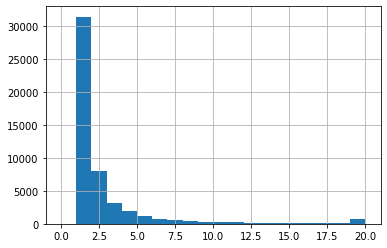

In [453]:
user_counts.hist(bins = np.arange(21));

In [454]:
toronto_reviews.business_id.nunique()

2707

In [455]:
toronto_reviews.user_id.nunique()

49549

In [456]:
# Change datetime column from object to date
toronto_reviews['year'] = pd.to_datetime(toronto_reviews.date).dt.year
toronto_reviews['date'] = pd.to_datetime(toronto_reviews.date).dt.date


/Users/paulgstubley/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/paulgstubley/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


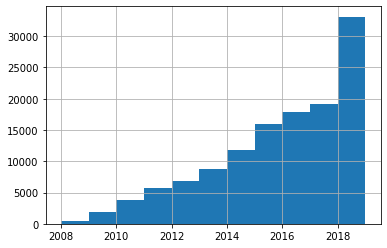

In [457]:
toronto_reviews.year.hist(bins=np.arange(2008,2020))

In [458]:
toronto_reviews.year.value_counts()

2017    19097
2018    18368
2016    17955
2015    15966
2019    14750
2014    11821
2013     8788
2012     6806
2011     5668
2010     3799
2009     1910
2008      504
Name: year, dtype: int64

In [501]:
toronto_reviews_sub = toronto_reviews[toronto_reviews.year>2014]


In [502]:
user_counts = toronto_reviews_sub[toronto_reviews_sub.year<2019].groupby('user_id').review_id.count()


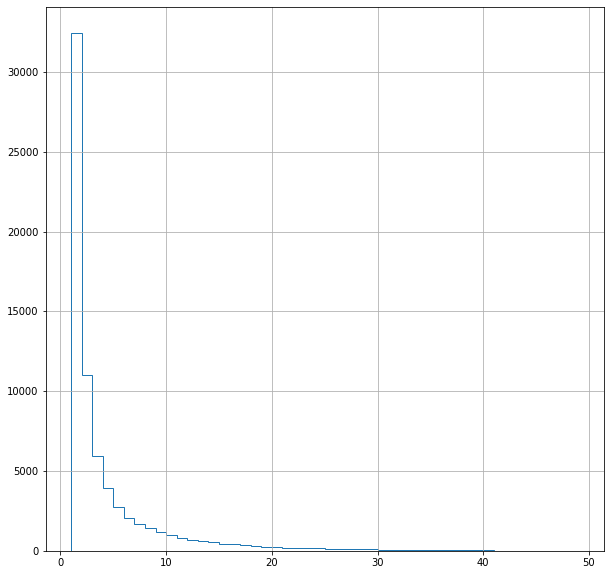

In [503]:
# How are the reviews made up?  The vast majority come from users who reviews just once.
# These users won't be much use for SVD.  We can see that ~10_000 users have more than 
# who have reviewed 5 or more times, I will use just these ones to begin with.
user_counts.hist(histtype='step',cumulative=-1, bins=np.arange(1,50), figsize = (10,10))

number_of_reviews = []

for n in range(0,51,5):
    top_users = user_counts[user_counts>=n].index
    number_of_reviews.append([n,toronto_reviews_sub[(toronto_reviews_sub.year<2019) & (toronto_reviews_sub.user_id.isin(top_users))].shape[0]])

number_of_reviews = np.array(number_of_reviews)
    

In [504]:
number_of_reviews

array([[    0, 71386],
       [    5, 28995],
       [   10, 17941],
       [   15, 11709],
       [   20,  8029],
       [   25,  5712],
       [   30,  4304],
       [   35,  3302],
       [   40,  2387],
       [   45,  1806],
       [   50,  1524]])

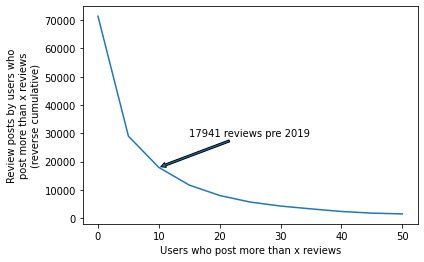

In [539]:
plt.plot(number_of_reviews[:,0],number_of_reviews[:,1])
plt.ylabel('Review posts by users who\npost more than x reviews\n(reverse cumulative)')
plt.xlabel('Users who post more than x reviews');
# Who is defined as a power_user
keep = 10
keep_id = int(keep/5)
plt.annotate(s = '{} reviews pre 2019'.format(number_of_reviews[keep_id,1])
             , xy = (number_of_reviews[keep_id,0],number_of_reviews[keep_id,1])
             , xytext = (number_of_reviews[keep_id+1,0],number_of_reviews[keep_id-1,1])
             , arrowprops = {'arrowstyle': 'simple'});


In [523]:
# Cut the review df to just those users who've made 20 or more reviews between 2014-2018 inc
top_users = user_counts[user_counts>=keep]
toronto_reviews_sub = toronto_reviews_sub[toronto_reviews_sub.user_id.isin(top_users.index)]

In [600]:
print('{} power users with {} reviews (2015-19) for {} restaurants'.format(len(top_users), toronto_reviews_sub.shape[0],  toronto_reviews_sub.business_id.nunique()))


1019 power users with 20390 reviews (2015-19) for 1943 restaurants


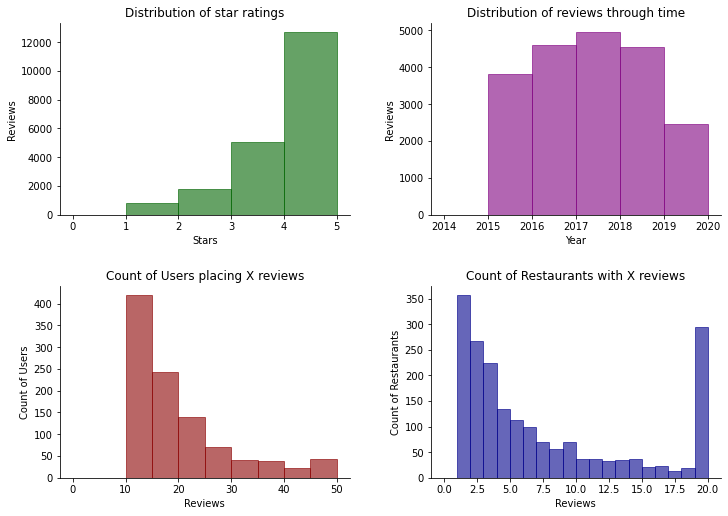

In [613]:
def format_chart(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig,ax = plt.subplots(2,2, figsize = (11,8))
fig.tight_layout(pad = 5.0)

toronto_reviews_sub.stars.hist(bins=range(6), color = 'darkgreen', ax=ax[0][0], alpha=0.6, edgeColor = 'darkgreen')
format_chart(ax[0][0], 'Distribution of star ratings','Stars','Reviews')

toronto_reviews_sub.year.hist(bins = np.arange(2014,2021,1), ax=ax[0][1] , alpha = 0.6, color = 'purple', edgeColor = 'purple')
format_chart(ax[0][1], 'Distribution of reviews through time','Year','Reviews')

user_counts.hist(bins = np.arange(0,51,5), ax=ax[1][0], color = 'darkred', alpha = 0.6, edgeColor = 'darkred')
format_chart(ax[1][0], 'Count of Users placing X reviews','Reviews','Count of Users')

business_counts = toronto_reviews_sub.groupby('business_id').review_id.count()
business_counts[business_counts > 20] = 20      

business_counts.hist(bins = np.arange(21), ax=ax[1][1], color = 'darkblue', alpha = 0.6, edgeColor = 'darkblue')
format_chart(ax[1][1], 'Count of Restaurants with X reviews','Reviews','Count of Restaurants')

In [619]:
toronto_reviews_sub.to_json('toronto_reviews_sub.json', orient='records')
df_businesses_toronto.to_json('businesses_toronto.json', orient='records')

### <a class="anchor" id="Initial-FunkSVD-Model"> Initial FunkSVD Model </a>


#### Split train and test

In [633]:
toronto_reviews_train = toronto_reviews_sub[toronto_reviews_sub.year <2019]
toronto_reviews_test = toronto_reviews_sub[toronto_reviews_sub.year == 2019]

Drop all but the most recent review from each user for each restaurant - thinking being that their most recent review will affect their future behaviour more

In [634]:
print('Before, # reviews: ',len(toronto_reviews_train))
toronto_reviews_train = toronto_reviews_train[~toronto_reviews_train.duplicated(subset=['user_id','business_id'],keep='last')]
print('After,  # reviews: ', len(toronto_reviews_train))


Before, # reviews:  17941
After,  # reviews:  17157


Create user_by_restaurant table

In [636]:
toronto_reviews_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,city,year
397248,NnB7PoqJPrlzCl3ayQjvIw,Kj9cFO70zZOQorN0mgeLWA,Z2QohwGZOSqutdlU2xDWJw,4.0,0,0,1,2015-01-01,Toronto,2015
362610,dQqSOfur1w463gS0FW14Sg,x2o4DyS9DUUTD2S0vwlDCQ,yU4zevCwPAQIMb73smTHog,3.0,0,0,1,2015-01-01,Toronto,2015
248033,MXnL6VPVDtlFOYsfVQjqaQ,c9NbdAJy9eOGGc_i3UKuKQ,qo9JoIB9iZxGl-KQGDzEWw,3.0,0,0,0,2015-01-01,Toronto,2015
105048,A1oLgG6m5dT-wcoTNSY73A,FREeRQtjdJU83AFtdETBBw,kZh-0f291AiayMgs1EqwIQ,3.0,1,0,1,2015-01-01,Toronto,2015
390059,180bxHHNe94oCROK54Cyvg,G-9ujgKmc1J2k7HSqXszsw,UsKmYp0m8VYWM96tkGm2vQ,4.0,1,0,0,2015-01-01,Toronto,2015


In [637]:
user_by_restaurant = toronto_reviews_train[['user_id','business_id','stars']].groupby(['user_id', 'business_id'])['stars'].max().unstack()


In [638]:
user_by_restaurant

business_id,--DaPTJW3-tB1vP-PfdTEg,--SrzpvFLwP_YFwB_Cetow,-0aOudcaAyac0VJbMX-L1g,-6mzdR0YjOToJ8E04Y9O0Q,-BVqCPibTNPCNeT0uJsiRg,-CLTZ0cO-ooKDDmXHFoGMg,-ClafaRWkSRTfieIzO4r3Q,-HwprJh-Bve1pcDH8_UFeQ,-IXNFjtECsn8fqF047tYFw,-OxDX2fPQLYi6ChW2Z6xxQ,...,zeiaHxtK2fTUz_jlPdIKPQ,ziLoZvl1mEuDYlndTezRZw,ziiVVWwlQbvk6fqvPt-RsA,zm7e0hmW4aPvoRsAdqqEyA,zqPAwZbi5rS1dyHrKzDpMg,zrYpLdnGKA_EmOhgRCy_vg,zvtkeghW0Px5HY9QkJ4INw,zwGu5H7MnilB9Fw7DZ7kXQ,zy_NHTqtfSrfTGGPoqy4Mw,zzH3E5DA8eMzFwv2k5izyw
user_id,,,,,,,,,,,,,,,,,,,,,
--BumyUHiO_7YsHurb9Hkw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--Qh8yKWAvIP4V4K8ZPfHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3PTUP443q6hQESLKSu95w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
-9RU4LuI_TfYgv9rBijJoQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-ILapEusonY1QHyJPvUk2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zbSBmoujGgIPuNWQcny14g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zc3saQQEeTBQbk3GeqtxvA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zejQj99sR-Y9-rq_xpL9nw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [651]:
def FunkSVD(ratings_mat, latent_features=10, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, rxs as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    rx_mat - (numpy array) a latent feature by restaurant matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]  # number of rows in the matrix
    n_rxs = ratings_mat.shape[1] # number of rx in the matrix
    num_ratings = ratings_mat.size  # total number of ratings in the matrix
    
    # initialize the user and rx matrices with random values
    user_mat = np.random.rand(n_users,latent_features)# user matrix filled with random values of shape user x latent 
    rx_mat = np.random.rand(latent_features,n_rxs)# rx matrix filled with random values of shape latent x rx
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # timeit
    start = time.time()
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations\t| Mean Squared Error\t| ETA ")
    
    # for each iteration
    for i in range(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-rx pair
        for u in range(n_users):
            for m in range(n_rxs):
                # if the rating exists
                if np.isfinite(ratings_mat[u,m]):

                    # compute the error as the actual minus the dot product of the user and rx latent features
                    err = ratings_mat[u,m]-np.dot(user_mat[u,:],rx_mat[:,m])
                    # Keep track of the total sum of squared errors for the matrix
                    sse_accum += err**2
                    # update the values in each matrix in the direction of the gradient
                    user_mat[u,:] = user_mat[u,:] + learning_rate * 2 * err * rx_mat[:,m].T
                    rx_mat[:,m] = rx_mat[:,m] + learning_rate * 2 * err * user_mat[u,:].T
        # Update time
        ETA = (time.time()-start)/(i+1)*(iters-i-1)
        ETA_string = '{:.0f}m{:.0f}s'.format(ETA//60,ETA%60)
                    
                    
        # print results for iteration
        print("%d \t\t |%f \t\t| %s" % (i+1, sse_accum / num_ratings, ETA_string))
        
    return user_mat, rx_mat 





In [668]:
user_mat, rx_mat = FunkSVD(np.matrix(user_by_restaurant), latent_features=10, learning_rate=0.005, iters=25)# use your function with 4 latent features, lr of 0.005 and 10 iterations


Optimization Statistics
Iterations	| Mean Squared Error	| ETA 
1 		|0.017085 		| 1m54s
2 		|0.010352 		| 1m47s
3 		|0.008540 		| 1m42s
4 		|0.007685 		| 1m37s
5 		|0.007164 		| 1m32s
6 		|0.006791 		| 1m27s
7 		|0.006495 		| 1m23s
8 		|0.006244 		| 1m18s
9 		|0.006021 		| 1m14s
10 		|0.005818 		| 1m9s
11 		|0.005628 		| 1m5s
12 		|0.005448 		| 1m0s
13 		|0.005275 		| 0m55s
14 		|0.005108 		| 0m51s
15 		|0.004946 		| 0m46s
16 		|0.004789 		| 0m42s
17 		|0.004635 		| 0m37s
18 		|0.004486 		| 0m32s
19 		|0.004340 		| 0m28s
20 		|0.004199 		| 0m23s
21 		|0.004061 		| 0m18s
22 		|0.003928 		| 0m14s
23 		|0.003799 		| 0m9s
24 		|0.003675 		| 0m5s
25 		|0.003555 		| 0m0s


In [665]:
def predict_rating(user_matrix, rx_matrix, user_id, rx_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    rx_matrix - latent factor by rx matrix
    user_id - the user_id from the reviews df
    rx_id - the rx_id according the rxs df
    
    OUTPUT:
    pred - the predicted rating for user_id-rx_id according to FunkSVD
    '''
    # Use the training data to create a series of users and rxs that matches the ordering in training data
    rx_ids = toronto_reviews_train.business_id.sort_values().unique()
    user_ids = toronto_reviews_train.user_id.sort_values().unique()
    m_id = np.where(rx_ids==rx_id)[0][0]
    u_id = np.where(user_ids==user_id)[0][0]

    # User row and rx Column
    row = user_matrix[u_id,:]
    column = rx_matrix[:,m_id]
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(row,column)
    
    return pred

In [666]:


toronto_reviews_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,city,year
397248,NnB7PoqJPrlzCl3ayQjvIw,Kj9cFO70zZOQorN0mgeLWA,Z2QohwGZOSqutdlU2xDWJw,4.0,0,0,1,2015-01-01,Toronto,2015
362610,dQqSOfur1w463gS0FW14Sg,x2o4DyS9DUUTD2S0vwlDCQ,yU4zevCwPAQIMb73smTHog,3.0,0,0,1,2015-01-01,Toronto,2015
248033,MXnL6VPVDtlFOYsfVQjqaQ,c9NbdAJy9eOGGc_i3UKuKQ,qo9JoIB9iZxGl-KQGDzEWw,3.0,0,0,0,2015-01-01,Toronto,2015
105048,A1oLgG6m5dT-wcoTNSY73A,FREeRQtjdJU83AFtdETBBw,kZh-0f291AiayMgs1EqwIQ,3.0,1,0,1,2015-01-01,Toronto,2015
390059,180bxHHNe94oCROK54Cyvg,G-9ujgKmc1J2k7HSqXszsw,UsKmYp0m8VYWM96tkGm2vQ,4.0,1,0,0,2015-01-01,Toronto,2015


In [670]:
print(predict_rating(user_mat, rx_mat, 'Kj9cFO70zZOQorN0mgeLWA', 'Z2QohwGZOSqutdlU2xDWJw'))
print(predict_rating(user_mat, rx_mat, 'c9NbdAJy9eOGGc_i3UKuKQ', 'qo9JoIB9iZxGl-KQGDzEWw'))

3.4406092689803893
2.6805337680762538


In [675]:
def validation_comparison(val_df, user_mat=user_mat, rx_mat=rx_mat):
    '''
    INPUT:
    val_df - the validation dataset created in the third cell above
    user_mat - U matrix in FunkSVD
    rx_mat - V matrix in FunkSVD
        
    OUTPUT:
    rmse - RMSE of how far off each value is from it's predicted value
    perc_rated - percent of predictions out of all possible that could be rated
    actual_v_pred - a 10 x 10 grid with counts for actual vs predicted values
    '''
        
    val_users = np.array(val_df['user_id'])
    val_rxs = np.array(val_df['business_id'])
    val_ratings = np.array(val_df['stars'])
    
    sse = 0
    num_rated = 0
    preds, acts = [], []
    actual_v_pred = np.zeros((5,5))
    for idx in range(len(val_users)):
        try:
            pred = predict_rating(user_mat, rx_mat, val_users[idx], val_rxs[idx])
            sse += (val_ratings[idx] - pred)**2
            num_rated+=1
            preds.append(pred)
            acts.append(val_ratings[idx])
            actual_v_pred[11-int(val_ratings[idx]-1), int(round(pred)-1)]+=1
        
        except:
            continue
    
    rmse = np.sqrt(sse/num_rated)
    perc_rated = num_rated/len(val_users)
    return rmse, perc_rated, actual_v_pred, preds, acts

In [678]:
# How well did we do?
rmse, perc_rated, actual_v_pred, preds, acts = validation_comparison(toronto_reviews_test)
print(rmse, perc_rated)

1.0374110947415347 0.805634953042058


array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,  10.,  91., 253., 129.],
       [  2.,  25., 257., 412., 101.],
       [  1.,  28., 193., 224.,  27.]])

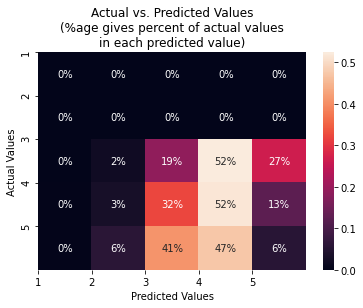

In [702]:
sns.heatmap(actual_v_pred/(actual_v_pred.sum(axis=1)[:, np.newaxis]+1E-6), annot=True, fmt='.0%')
plt.xticks(np.arange(5), np.arange(1,6));
plt.yticks(np.arange(5), np.arange(1,6));
plt.xlabel("Predicted Values");
plt.ylabel("Actual Values");
plt.title("Actual vs. Predicted Values\n(%age gives percent of actual values\nin each predicted value)");

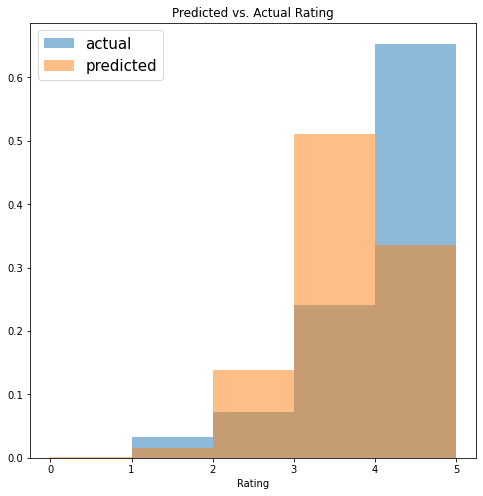

In [705]:
plt.figure(figsize=(8,8))
plt.hist(acts, density=True, alpha=.5, label='actual', bins=range(6));
plt.hist(preds, density=True, alpha=.5, label='predicted', bins=range(6));
plt.legend(loc=2, prop={'size': 15});
plt.xlabel('Rating');
plt.title('Predicted vs. Actual Rating');

## Combine this hist with the heatmap for a beaut plot